In [ ]:
!apt install unzip


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!unzip /content/archive1.zip -d /content/archive1

Archive:  /content/archive1.zip
  inflating: /content/archive1/Readme.txt  
  inflating: /content/archive1/data/Readme.txt  
  inflating: /content/archive1/data/subject01.centerlight  
  inflating: /content/archive1/data/subject01.glasses  
  inflating: /content/archive1/data/subject01.happy  
  inflating: /content/archive1/data/subject01.leftlight  
  inflating: /content/archive1/data/subject01.noglasses  
  inflating: /content/archive1/data/subject01.normal  
  inflating: /content/archive1/data/subject01.rightlight  
  inflating: /content/archive1/data/subject01.sad  
  inflating: /content/archive1/data/subject01.sleepy  
  inflating: /content/archive1/data/subject01.surprised  
  inflating: /content/archive1/data/subject01.wink  
  inflating: /content/archive1/data/subject02.centerlight  
  inflating: /content/archive1/data/subject02.glasses  
  inflating: /content/archive1/data/subject02.happy  
  inflating: /content/archive1/data/subject02.leftlight  
  inflating: /content/archive

In [ ]:
# 1. Create folder if not exists
import os
unknown_folder = "/content/unknown_test_images"
if not os.path.exists(unknown_folder):
    os.makedirs(unknown_folder)
    print(f"Folder '{unknown_folder}' created successfully.")
else:
    print(f"Folder '{unknown_folder}' already exists.")

Folder '/content/unknown_test_images' created successfully.


In [ ]:
#2.List all images in the folder
unknown_files = [
    os.path.join(unknown_folder, f)
    for f in os.listdir(unknown_folder)
    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
]
print(f"Found {len(unknown_files)} unknown test images")

Found 7 unknown test images


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import json
import pandas as pd
import math


This code loads all training images from the specified folder, using OpenCV's 'VideoCapture' to handle GIF files. For each image, it converts the frame to grayscale and applies histogram equalization to enhance contrast. The shape of the first image is stored for consistency. Each processed image is then flattened and normalized to the range [0, 1], and added to a list of face vectors for later analysis. Filenames are also saved for reference. This ensures all images are preprocessed uniformly, which is essential for reliable face recognition using Eigenfaces.


In [ ]:
folder = r"/content/archive1"
face_vectors = []
filenames = []
image_shape = None

for img_name in os.listdir(folder):
    img_path = os.path.join(folder, img_name)
    cap = cv2.VideoCapture(img_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        if image_shape is None:
            image_shape = gray.shape

        face_vectors.append(gray.flatten().astype(np.float64)/255.0)
        filenames.append(img_name)

print(f"Processed {len(face_vectors)} images. Image shape: {image_shape}")


Processed 165 images. Image shape: (243, 320)


In [ ]:
# Group images by subject
subject_dict = defaultdict(list)
for i, fname in enumerate(filenames):
    subject = fname.split('.')[0]
    subject_dict[subject].append(i)

train_indices, test_indices = [], []
for subject, indices in subject_dict.items():
    random.shuffle(indices)
    train_indices.extend(indices[:8])
    test_indices.extend(indices[8:])

# Create train and test splits
train_vectors = [face_vectors[i] for i in train_indices]
train_filenames = [filenames[i] for i in train_indices]
test_vectors = [face_vectors[i] for i in test_indices]
test_filenames = [filenames[i] for i in test_indices]


In [ ]:
# Save indices or filenames for reproducibility
with open('train_filenames.json', 'w') as f:
    json.dump(train_filenames, f)
with open('test_filenames.json', 'w') as f:
    json.dump(test_filenames, f)


In [ ]:
with open('train_filenames.json', 'r') as f:
    train_filenames = json.load(f)
with open('test_filenames.json', 'r') as f:
    test_filenames = json.load(f)

# If you need the corresponding vectors:
train_vectors = [face_vectors[filenames.index(fname)] for fname in train_filenames]
test_vectors = [face_vectors[filenames.index(fname)] for fname in test_filenames]


In [ ]:
Gamma = np.vstack(face_vectors).T  # Columns = face images
print(f"Data matrix Γ: {Gamma.shape}")


Data matrix Γ: (77760, 165)


In [ ]:
Gamma = np.vstack(train_vectors).T  # Columns = training face images
print(f"Training data matrix Γ: {Gamma.shape}")


Training data matrix Γ: (77760, 120)


Mean face Ψ: (77760,)


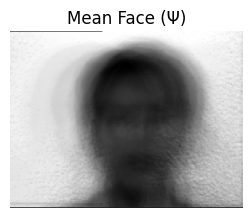

In [ ]:
Psi = np.mean(Gamma, axis=1)  # Paper: Eq. (1)
print(f"Mean face Ψ: {Psi.shape}")

plt.figure(figsize=(3, 3))
plt.imshow(Psi.reshape(image_shape), cmap='gray')
plt.title("Mean Face (Ψ)")
plt.axis('off')
plt.show()


In [ ]:
Phi = Gamma - Psi[:, np.newaxis]  # Paper: Eq. (2)
print(f"Centered matrix Φ: {Phi.shape}")


Centered matrix Φ: (77760, 120)


In [ ]:
# Direct SVD approach
U, S, Vt = np.linalg.svd(Phi, full_matrices=False)
eigenvalues = S**2

# Sort in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
U = U[:, idx]

print(f"Computed {len(eigenvalues)} eigenvalues")
print(f"Top 5 eigenvalues: {eigenvalues[:5]}")


Computed 120 eigenvalues
Top 5 eigenvalues: [209257.80754739  93327.86496819  45536.4255351   34961.13057621
  27898.10065409]


Using 47 eigenfaces (95.0% variance)


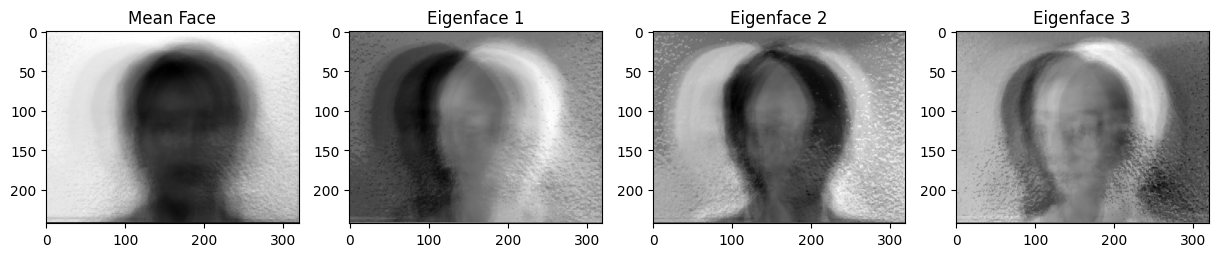

In [ ]:
# Select eigenfaces (95% variance)
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)  #calculates the running total of explained variance for each principal component.
M_prime = np.argmax(cumulative_variance >= 0.95) + 1  #Finds the smallest no. of eigenfaces needed to reach 95% of the total variance.
top_eigenfaces = U[:, :M_prime]  #selects the corresponding eigenfaces from SVD output.

print(f"Using {M_prime} eigenfaces ({cumulative_variance[M_prime-1]:.1%} variance)")

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(Psi.reshape(image_shape), cmap='gray')
plt.title("Mean Face")

for i in range(min(3, M_prime)):
    plt.subplot(1, 4, i+2)
    plt.imshow(top_eigenfaces[:, i].reshape(image_shape), cmap='gray')
    plt.title(f"Eigenface {i+1}")
plt.show()


In [ ]:
train_weights = top_eigenfaces.T @ Phi  # Paper: Eq. (7)
print(f"Training weights shape: {train_weights.shape}")


Training weights shape: (47, 120)


In [ ]:
# Assuming you have train_filenames (list of training image filenames)
face_classes = {}
subjects = set([f.split('.')[0] for f in train_filenames])

for subject in subjects:
    # Only look up indices in the training set
    subject_indices = [i for i, f in enumerate(train_filenames) if f.startswith(subject)]
    subject_weights = train_weights[:, subject_indices]
    omega_k = subject_weights.mean(axis=1)
    face_classes[subject] = omega_k

print(f"Created {len(face_classes)} face classes\n")
print("Mean eigenface weights (omega_k) for each subject:\n")

subject_sorted = sorted(list(face_classes.keys()))
for k, subject in enumerate(subject_sorted, 1):
  omega_k = face_classes[subject]
  print(f"(subject:{subject}), omega_{k} shape: {omega_k.shape}")
  print(omega_k)


Created 15 face classes

Mean eigenface weights (omega_k) for each subject:

(subject:subject01), omega_1 shape: (47,)
[-1.59232911e+01  9.38585564e+00 -2.38126683e+01 -2.06872980e+00
 -2.03229538e+01  5.05868721e+00  1.36079609e+01  5.43413019e+00
  2.43794546e+00 -1.72292625e+01  2.90255930e-01 -7.74167564e+00
 -4.07418502e+00  3.54355614e+00  6.05298597e+00  4.43847625e+00
 -7.04778577e-01  3.01893835e+00  2.81372416e+00 -1.67390076e+00
  2.87755185e+00  1.89495701e+00 -1.65891660e-01  5.02612870e-01
 -9.71555528e-01 -4.32924567e-02 -3.47484079e-01 -1.15003005e+00
 -2.07123726e-01 -2.15809775e-01  6.19442409e-01 -2.09634397e+00
 -1.88512987e-01  4.90557002e-01 -8.74815157e-01  4.05449505e-01
 -1.47700790e+00  1.19322120e+00  4.61039708e-01  6.20065593e-01
 -6.60082533e-03 -3.97114690e-01 -1.71239465e-01 -1.44623920e-01
 -2.50164564e-01  1.90931520e-01  9.19913049e-02]
(subject:subject02), omega_2 shape: (47,)
[-4.74354170e+01 -2.60599582e+01 -4.06923186e+00  5.96071841e+00
 -8.13500

In [ ]:
def load_gif_as_gray_vector(img_path, image_shape=None):
    cap = cv2.VideoCapture(img_path)
    ret, frame = cap.read()
    cap.release()
    if not ret or frame is None:
        raise ValueError(f"Failed to load image: {img_path}")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    if image_shape is not None:
        gray = cv2.resize(gray, (image_shape[1], image_shape[0]))
    return gray


In [ ]:
# Load fixed test filenames
with open('test_filenames.json', 'r') as f:
    test_filenames = json.load(f)

folder = r"/content/archive1"

# Process each test image using VideoCapture (for GIFs)
for fname in test_filenames:
    img_path = os.path.join(folder, fname)
    try:
        gray = load_gif_as_gray_vector(img_path, image_shape)
        img_vector = gray.flatten().astype(np.float64) / 255.0
        omega_test = top_eigenfaces.T @ (img_vector - Psi)
        print(f"\nTest image: {fname}")
        print(f"omega (eigenface weights):\n{omega_test}")
        print(f"omega_test shape for {fname}: {omega_test.shape}")
    except Exception as e:
        print(f"Failed to process {fname}: {e}")



Test image: subject04.surprised
omega (eigenface weights):
[-3.89869826e+01 -8.72190961e+00 -7.60620555e+00  3.58433823e+00
 -1.00336096e+01  1.06344404e+01 -3.66623956e+00 -1.25562948e+01
 -9.13928811e+00  1.63626855e+01  1.79402248e+01 -1.20085128e+01
  9.33579696e-01 -3.70948461e+00  5.54928302e+00  2.80647916e+00
 -5.20716840e+00 -3.08596494e+00  3.01773821e+00 -1.04960727e+00
 -4.76764149e-01 -1.81306152e+00  2.94522685e-01 -9.93665020e-01
 -8.78539333e-01 -1.01127630e+00 -5.12502195e-01  9.95354776e-01
 -1.01069382e+00  2.36463599e+00  2.84993053e-01  1.94195437e+00
  8.10187683e-01  2.80538794e+00 -5.46813970e-01 -5.78981648e-01
 -4.01673814e-01 -4.43040855e-01  6.61504317e-01 -3.09004277e+00
  1.64906943e-01 -3.30356094e-02 -5.75477065e-01  1.96939639e+00
  6.24236992e-01  4.51883759e-01 -1.60028020e+00]
omega_test shape for subject04.surprised: (47,)

Test image: subject04.centerlight
omega (eigenface weights):
[-26.18531445  15.17567297 -20.65034469   9.82978834 -14.84072384

In [ ]:
#finding theta_c using the whole dataset images
all_epsilon_ks = [] # List to store the minimum distance (epsilon_k) to the closest subject for each image

for idx, img_vector in enumerate(face_vectors):  # Loop over every image in the dataset
    # Project image into face space
    phi = img_vector - Psi
    omega_test = top_eigenfaces.T @ phi

    # Compute epsilon_k for all classes
    epsilons = []  # List to store distances to each subject's mean face in eigenface space
    for subject, omega_k in face_classes.items():
        epsilon_k = np.linalg.norm(omega_test - omega_k)
        epsilons.append((subject, epsilon_k))

    # Find the minimum epsilon_k and its subject
    min_subject, min_epsilon_k = min(epsilons, key=lambda x: x[1]) # Find the subject with the minimum distance (closest match)
    all_epsilon_ks.append(min_epsilon_k)

    print(f"Image {idx+1}: Closest subject = {min_subject}, ε_k = {min_epsilon_k:.3f}")

# Now set theta_c as the maximum of all min_epsilon_k
theta_c = 0.61 * max(all_epsilon_ks)
print(f"\nTraining ε_k range: [{min(all_epsilon_ks):.3f}, {max(all_epsilon_ks):.3f}]")
print(f"theta_c = {theta_c:.3f}")


Image 1: Closest subject = subject12, ε_k = 55.040
Image 2: Closest subject = subject03, ε_k = 30.446
Image 3: Closest subject = subject04, ε_k = 16.524
Image 4: Closest subject = subject03, ε_k = 40.435
Image 5: Closest subject = subject06, ε_k = 42.791
Image 6: Closest subject = subject04, ε_k = 18.618
Image 7: Closest subject = subject07, ε_k = 21.802
Image 8: Closest subject = subject14, ε_k = 24.335
Image 9: Closest subject = subject01, ε_k = 42.641
Image 10: Closest subject = subject06, ε_k = 23.662
Image 11: Closest subject = subject12, ε_k = 51.444
Image 12: Closest subject = subject10, ε_k = 22.153
Image 13: Closest subject = subject04, ε_k = 20.041
Image 14: Closest subject = subject13, ε_k = 21.579
Image 15: Closest subject = subject01, ε_k = 23.850
Image 16: Closest subject = subject12, ε_k = 51.444
Image 17: Closest subject = subject12, ε_k = 54.311
Image 18: Closest subject = subject11, ε_k = 20.019
Image 19: Closest subject = subject12, ε_k = 33.842
Image 20: Closest sub

In [ ]:
epsilons_square = {}  # Dictionary to store the list of reconstruction errors for each subject
subjects = set([f.split('.')[0] for f in filenames]) #Extract unique subject names from filenames
all_epsilons = [] # List to store all reconstruction errors (epsilon^2) for all images

for subject in sorted(subjects):
    subject_indices = [i for i, f in enumerate(filenames) if f.startswith(subject)]
    eps_sq_list = [] # List to store epsilon^2 values for this subject
    for idx in subject_indices: # Loop through all images of the current subject
        img_vector = face_vectors[idx]  # Get the image vector (flattened grayscale image)
        phi = img_vector - Psi
        omega = top_eigenfaces.T @ phi
        phi_proj = top_eigenfaces @ omega
        epsilon_sq = np.sum((phi - phi_proj)**2)
        eps_sq_list.append(epsilon_sq)
        all_epsilons.append(epsilon_sq)
        print(f"Subject {subject}, Image {idx+1}: ε² = {epsilon_sq:.3f}, ε = {np.sqrt(epsilon_sq):.3f}")
    epsilons_square[subject] = eps_sq_list

theta_e = max(all_epsilons)

print(f"Training ε² range: [{min(all_epsilons):.3f}, {max(all_epsilons):.3f}]")
print(f"Training ε range: [{np.sqrt(min(all_epsilons)):.3f}, {np.sqrt(max(all_epsilons)):.3f}]")
print(f"theta_e = {theta_e:.3f}")


Subject subject01, Image 9: ε² = 208.737, ε = 14.448
Subject subject01, Image 15: ε² = 403.521, ε = 20.088
Subject subject01, Image 23: ε² = 379.498, ε = 19.481
Subject subject01, Image 24: ε² = 533.001, ε = 23.087
Subject subject01, Image 83: ε² = 289.535, ε = 17.016
Subject subject01, Image 87: ε² = 1557.711, ε = 39.468
Subject subject01, Image 101: ε² = 271.636, ε = 16.481
Subject subject01, Image 115: ε² = 370.431, ε = 19.247
Subject subject01, Image 119: ε² = 367.374, ε = 19.167
Subject subject01, Image 126: ε² = 844.106, ε = 29.054
Subject subject01, Image 132: ε² = 392.177, ε = 19.803
Subject subject02, Image 40: ε² = 382.106, ε = 19.548
Subject subject02, Image 46: ε² = 327.246, ε = 18.090
Subject subject02, Image 60: ε² = 166.861, ε = 12.917
Subject subject02, Image 89: ε² = 178.087, ε = 13.345
Subject subject02, Image 90: ε² = 301.396, ε = 17.361
Subject subject02, Image 104: ε² = 166.861, ε = 12.917
Subject subject02, Image 109: ε² = 365.880, ε = 19.128
Subject subject02, Im

In [ ]:

def recognize_image_case(
    img_path, Psi, top_eigenfaces, image_shape, face_classes, theta_c, theta_e, display=True
):
    # Try to load as image
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        # If not an image, try to load as video and grab first frame
        cap = cv2.VideoCapture(img_path)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            print(f"Could not load {img_path} as image or video")
            return "Cannot read image", None, None, None, None
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Preprocess
    gray = cv2.equalizeHist(gray)
    gray = cv2.resize(gray, (image_shape[1], image_shape[0]))
    test_vector = gray.flatten().astype(np.float64) / 255.0

    # Project into face space
    phi = test_vector - Psi
    omega_test = top_eigenfaces.T @ phi
    phi_proj = top_eigenfaces @ omega_test

    # Distance to face space (reconstruction error)
    epsilon_sq = np.sum((phi - phi_proj) ** 2)
    epsilon = np.sqrt(epsilon_sq)

    # Distance to each class
    epsilons = {}
    for subject, omega_k in face_classes.items():
        epsilon_k = np.linalg.norm(omega_test - omega_k)
        epsilons[subject] = epsilon_k
    min_subject = min(epsilons, key=epsilons.get)
    min_epsilon_k = epsilons[min_subject]

    # Classification logic (four cases)
    if epsilon_sq <= theta_e:
        if min_epsilon_k <= theta_c:
            case = 1
            result = f"Case 1: Recognized as {min_subject} (known face)"
        else:
            case = 2
            result = "Case 2: Unknown face (not in database, but a face)"
    else:
        if min_epsilon_k < theta_c:
            case = 3
            result = f"Case 3: Not a face, but similar to known subject {min_subject} (false positive)"
        else:
            case = 4
            result = "Case 4: Not a face (unknown)"

    # Print and/or display
    print(f"Image: {os.path.basename(img_path)}")
    print(f"  Distance to face space (epsilon^2): {epsilon_sq:.3f}, (epsilon): {epsilon:.3f}")
    print(f"  Distance to nearest class (epsilon_k): {min_epsilon_k:.3f} (subject: {min_subject})")
    print(f"  {result}\n")

    return case, result, epsilon_sq, min_epsilon_k, min_subject



In [ ]:
#for all images
results = []
for img_name in filenames:
    img_path = os.path.join(folder, img_name)
    case, result, epsilon_sq, min_epsilon_k, min_subject = recognize_image_case(
        img_path, Psi, top_eigenfaces, image_shape, face_classes, theta_c, theta_e, display=False
    )
    results.append({
        'image': img_name,
        'case': case,
        'result': result,
        'recognized_as': min_subject,
        'epsilon_sq': epsilon_sq,
        'epsilon': np.sqrt(epsilon_sq) if epsilon_sq is not None else None,
        'epsilon_k': min_epsilon_k
    })


Image: subject13.leftlight
  Distance to face space (epsilon^2): 311.264, (epsilon): 17.643
  Distance to nearest class (epsilon_k): 55.040 (subject: subject12)
  Case 2: Unknown face (not in database, but a face)

Image: subject03.glasses
  Distance to face space (epsilon^2): 405.351, (epsilon): 20.133
  Distance to nearest class (epsilon_k): 30.446 (subject: subject03)
  Case 1: Recognized as subject03 (known face)

Image: subject04.surprised
  Distance to face space (epsilon^2): 497.769, (epsilon): 22.311
  Distance to nearest class (epsilon_k): 16.524 (subject: subject04)
  Case 1: Recognized as subject04 (known face)

Image: subject03.centerlight
  Distance to face space (epsilon^2): 344.080, (epsilon): 18.549
  Distance to nearest class (epsilon_k): 40.435 (subject: subject03)
  Case 1: Recognized as subject03 (known face)

Image: subject06.surprised
  Distance to face space (epsilon^2): 142.485, (epsilon): 11.937
  Distance to nearest class (epsilon_k): 42.791 (subject: subject0

In [ ]:
##for test images only
results = []
for img_name, img_vector in zip(test_filenames, test_vectors):
    phi = img_vector - Psi
    omega_test = top_eigenfaces.T @ phi
    phi_proj = top_eigenfaces @ omega_test
    epsilon_sq = np.sum((phi - phi_proj) ** 2)
    epsilon = np.sqrt(epsilon_sq)
    epsilons = {}
    for subject, omega_k in face_classes.items():
        epsilon_k = np.linalg.norm(omega_test - omega_k)
        epsilons[subject] = epsilon_k
    min_subject = min(epsilons, key=epsilons.get)
    min_epsilon_k = epsilons[min_subject]

    # Classification logic (adapted from recognize_image_case)
    if epsilon_sq <= theta_e:
        if min_epsilon_k <= theta_c:
            case = 1
            result = f"Case 1: Recognized as {min_subject} (known face)"
        else:
            case = 2
            result = "Case 2: Unknown face (not in database, but a face)"
    else:
        if min_epsilon_k < theta_c:
            case = 3
            result = f"Case 3: Not a face, but similar to known subject {min_subject} (false positive)"
        else:
            case = 4
            result = "Case 4: Not a face (unknown)"

    print(f"Test image: {img_name}")
    print(f"  Distance to face space (epsilon^2): {epsilon_sq:.3f}, (epsilon): {epsilon:.3f}")
    print(f"  Distance to nearest class (epsilon_k): {min_epsilon_k:.3f} (subject: {min_subject})")
    print(f"  {result}\n")

    results.append({
        'image': img_name,
        'case': case,
        'result': result,
        'recognized_as': min_subject,
        'epsilon_sq': epsilon_sq,
        'epsilon': epsilon,
        'epsilon_k': min_epsilon_k
    })


Test image: subject04.surprised
  Distance to face space (epsilon^2): 497.769, (epsilon): 22.311
  Distance to nearest class (epsilon_k): 16.524 (subject: subject04)
  Case 1: Recognized as subject04 (known face)

Test image: subject04.centerlight
  Distance to face space (epsilon^2): 898.590, (epsilon): 29.976
  Distance to nearest class (epsilon_k): 40.166 (subject: subject01)
  Case 1: Recognized as subject01 (known face)

Test image: subject04.noglasses
  Distance to face space (epsilon^2): 633.001, (epsilon): 25.160
  Distance to nearest class (epsilon_k): 19.941 (subject: subject04)
  Case 1: Recognized as subject04 (known face)

Test image: subject03.noglasses
  Distance to face space (epsilon^2): 184.841, (epsilon): 13.596
  Distance to nearest class (epsilon_k): 33.803 (subject: subject03)
  Case 1: Recognized as subject03 (known face)

Test image: subject03.happy
  Distance to face space (epsilon^2): 217.029, (epsilon): 14.732
  Distance to nearest class (epsilon_k): 33.097 (

In [ ]:
df = pd.DataFrame(results)
print(df[['image', 'case', 'result', 'recognized_as', 'epsilon_sq', 'epsilon', 'epsilon_k']])


                    image  case  \
0     subject04.surprised     1   
1   subject04.centerlight     1   
2     subject04.noglasses     1   
3     subject03.noglasses     1   
4         subject03.happy     1   
5     subject03.surprised     1   
6           subject09.sad     1   
7     subject09.leftlight     1   
8         subject09.happy     1   
9         subject14.happy     1   
10          subject14.sad     1   
11   subject14.rightlight     2   
12    subject15.leftlight     2   
13        subject15.happy     1   
14    subject15.surprised     1   
15        subject08.happy     1   
16      subject08.glasses     1   
17         subject08.wink     1   
18       subject05.sleepy     1   
19   subject05.rightlight     2   
20          subject05.sad     1   
21      subject07.glasses     1   
22         subject07.wink     1   
23    subject07.noglasses     1   
24          subject10.sad     1   
25    subject10.leftlight     1   
26       subject10.normal     1   
27    subject13.nogl

Evaluates the Eigenfaces recognition system on all training images, printing the result, status, reconstruction error ($\epsilon^2$), and minimum distance ($\epsilon_k$) for each image, and summarizes overall accuracy.

In [ ]:
case_counts = df['case'].value_counts().sort_index()
print("Classification summary:")
print(f"Known faces (Case 1):     {case_counts.get(1, 0)}")
print(f"Unknown faces (Case 2):   {case_counts.get(2, 0)}")
print(f"Not a face (Case 3):      {case_counts.get(3, 0)}")
print(f"Not a face (Case 4):      {case_counts.get(4, 0)}")


Classification summary:
Known faces (Case 1):     39
Unknown faces (Case 2):   6
Not a face (Case 3):      0
Not a face (Case 4):      0


In [ ]:
# 1. Extract true label
df['true_label'] = df['image'].apply(lambda x: x.split('.')[0])

# 2. Determine correct recognitions
df['correct'] = (df['case'] == 1) & (df['recognized_as'] == df['true_label'])

# 3. Count and print
num_correct = df['correct'].sum()
total_images = len(df)
accuracy = num_correct / total_images

print(f"Correctly recognized: {num_correct} / {total_images}")
print(f"Overall accuracy: {accuracy:.2%}")


Correctly recognized: 31 / 45
Overall accuracy: 68.89%


Image: dog.png
  Distance to face space (epsilon^2): 6651.691, (epsilon): 81.558
  Distance to nearest class (epsilon_k): 96.553 (subject: subject06)
  Case 4: Not a face (unknown)



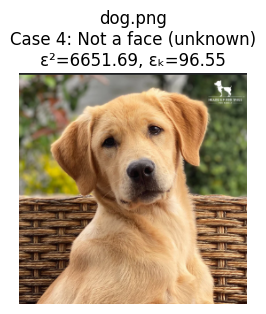

Image: apple.png
  Distance to face space (epsilon^2): 3854.868, (epsilon): 62.088
  Distance to nearest class (epsilon_k): 57.883 (subject: subject13)
  Case 4: Not a face (unknown)



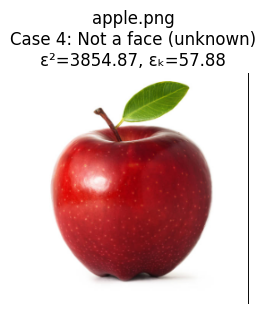

Image: face.png
  Distance to face space (epsilon^2): 2821.327, (epsilon): 53.116
  Distance to nearest class (epsilon_k): 54.982 (subject: subject04)
  Case 2: Unknown face (not in database, but a face)



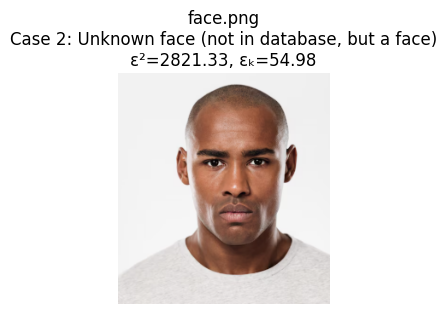

Image: cat.png
  Distance to face space (epsilon^2): 5863.896, (epsilon): 76.576
  Distance to nearest class (epsilon_k): 100.223 (subject: subject06)
  Case 4: Not a face (unknown)



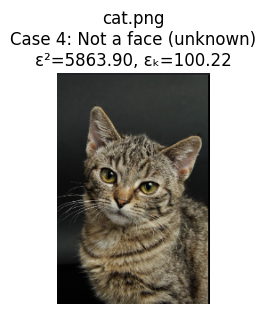

Image: button.png
  Distance to face space (epsilon^2): 3926.665, (epsilon): 62.663
  Distance to nearest class (epsilon_k): 64.074 (subject: subject12)
  Case 4: Not a face (unknown)



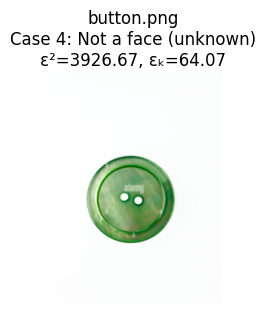

Image: clock.png
  Distance to face space (epsilon^2): 4417.959, (epsilon): 66.468
  Distance to nearest class (epsilon_k): 86.674 (subject: subject12)
  Case 4: Not a face (unknown)



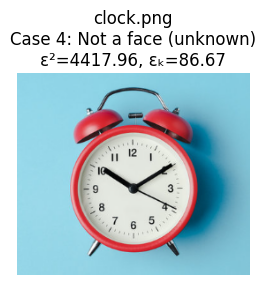

Image: subject01.happy.png
  Distance to face space (epsilon^2): 370.431, (epsilon): 19.247
  Distance to nearest class (epsilon_k): 23.462 (subject: subject01)
  Case 1: Recognized as subject01 (known face)



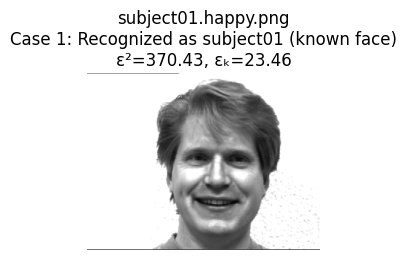

Image: face2.png
  Distance to face space (epsilon^2): 2294.288, (epsilon): 47.899
  Distance to nearest class (epsilon_k): 76.850 (subject: subject15)
  Case 2: Unknown face (not in database, but a face)



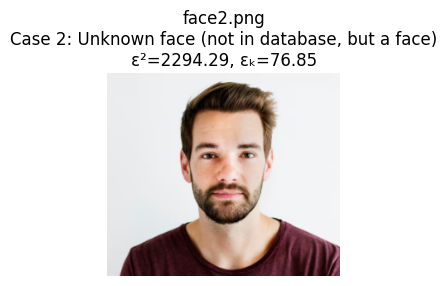

In [ ]:
unknown_folder = "/content/unknown_test_images"
unknown_filenames = os.listdir(unknown_folder)

unknown_results = []
for img_name in unknown_filenames:
    img_path = os.path.join(unknown_folder, img_name)
    case, result, epsilon_sq, min_epsilon_k, min_subject = recognize_image_case(
        img_path, Psi, top_eigenfaces, image_shape, face_classes, theta_c, theta_e, display=False
    )
    unknown_results.append({
        'image': img_name,
        'case': case,
        'result': result,
        'recognized_as': min_subject,
        'epsilon_sq': epsilon_sq,
        'epsilon': np.sqrt(epsilon_sq) if epsilon_sq is not None else None,
        'epsilon_k': min_epsilon_k
    })

    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(3,3))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"{img_name}\n{result}\nε²={epsilon_sq:.2f}, εₖ={min_epsilon_k:.2f}")
        plt.show()
    else:
        print(f"Could not load image: {img_name}")


In [ ]:
df_unknown = pd.DataFrame(unknown_results)

# Count how many are in each case
case_counts = df_unknown['case'].value_counts().sort_index()
print("\nUnknown Images Classification Summary:")
print(f"Known faces (Case 1):     {case_counts.get(1, 0)}")
print(f"Unknown faces (Case 2):   {case_counts.get(2, 0)}")
print(f"Not a face (Case 3):      {case_counts.get(3, 0)}")
print(f"Not a face (Case 4):      {case_counts.get(4, 0)}")

print(df_unknown[['image', 'case', 'result', 'recognized_as', 'epsilon_sq', 'epsilon', 'epsilon_k']])
print(type(df_unknown['case']))


Unknown Images Classification Summary:
Known faces (Case 1):     1
Unknown faces (Case 2):   2
Not a face (Case 3):      0
Not a face (Case 4):      5
                 image  case  \
0              dog.png     4   
1            apple.png     4   
2             face.png     2   
3              cat.png     4   
4           button.png     4   
5            clock.png     4   
6  subject01.happy.png     1   
7            face2.png     2   

                                              result recognized_as  \
0                       Case 4: Not a face (unknown)     subject06   
1                       Case 4: Not a face (unknown)     subject13   
2  Case 2: Unknown face (not in database, but a f...     subject04   
3                       Case 4: Not a face (unknown)     subject06   
4                       Case 4: Not a face (unknown)     subject12   
5                       Case 4: Not a face (unknown)     subject12   
6       Case 1: Recognized as subject01 (known face)     subject01   